This spam classifier uses Bayesian Decision Theory

Using Bayes' Theorem, the posterior probabilities of a message being spam or ham are calculated as:
- P(Spam ∣ Message) = P(Message ∣ Spam) P(Spam) / P(Message)
​
- P(Ham ∣ Message) = P(Message ∣ Ham) P(Ham) / P(Message)
​


In [55]:
import pandas as pd
import numpy as np

Step 1: Load the Dataset

In [56]:
df = pd.read_csv('./data/sms_dataset.csv')

In [57]:
print(df.shape)
df.head()

(5574, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


- Step 2: Preprocess the Data
    - Convert labels into binary values (e.g., 1 for spam, 0 for ham).
    - Clean and tokenize the messages:
    - Convert to lowercase.
    - Remove stop words, punctuation, and non-alphanumeric characters.

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_mapping = {'spam': 1, 'ham': 0}
df['label'] = df['label'].map(label_mapping)   # spam -> 1, ham -> 0

# Split into training and test sets ( 20 %)
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)

# Convert messages into a bag-of-words representation
vectorizer = CountVectorizer(stop_words="english")
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

Step 3: Define Priors
- P(spam) = Number of spam messages / total messages
- P(ham) = Number of ham messages / total messages

In [59]:
spam_prior = y_train.mean()
ham_prior = 1 - spam_prior
print(f"P(spam): {spam_prior :4f}, \nP(ham):  {ham_prior :4f}")


P(spam): 0.131420, 
P(ham):  0.868580


Step 4: Likelihood Calculation
- Use word counts to calculate likelihood:
    - For each word W: P(W | spam) and P(W | ham)
    


In [60]:
y_train_np = np.array(y_train)

# Sum word occurrences for each class
spam_word_count = X_train_transformed[y_train_np == 1].sum(axis=0)
ham_word_count = X_train_transformed[y_train_np == 0].sum(axis=0)

# Total words in each class
spam_total = spam_word_count.sum() + 1  # Laplace smoothing to handle words that may not appear in one class
ham_total = ham_word_count.sum() + 1

# Vocabulary size
vocabulary_size = X_train_transformed.shape[1]

# Likelihoods
spam_likelihood = (spam_word_count + 1) / (spam_total + vocabulary_size)
ham_likelihood = (ham_word_count + 1) / (ham_total + vocabulary_size)

print("Spam likelihoods:", spam_likelihood)
print("Ham likelihoods:", ham_likelihood)


Spam likelihoods: [[5.36800668e-04 1.55075749e-03 5.96445187e-05 ... 5.96445187e-05
  1.19289037e-04 5.96445187e-05]]
Ham likelihoods: [[2.89410471e-05 2.89410471e-05 5.78820942e-05 ... 5.78820942e-05
  2.89410471e-05 5.78820942e-05]]


Step 5: Compute Posterior Probabilities
- Use Bayes' theorem:

In [61]:
def calculate_posterior(message, spam_prior, ham_prior, spam_likelihood, ham_likelihood):
    # Convert the message into a word frequency vector
    words = vectorizer.transform([message])

    # Calculate the likelihood of the message given each class
    P_message_given_spam = np.prod(np.power(spam_likelihood, words.toarray()))
    P_message_given_ham = np.prod(np.power(ham_likelihood, words.toarray()))

    spam_posterior = P_message_given_spam * spam_prior
    ham_posterior = P_message_given_ham * ham_prior

    # Normalize to get probabilities 
    normalization_factor = spam_posterior + ham_posterior
    spam_posterior /= normalization_factor
    ham_posterior /= normalization_factor

    return spam_posterior, ham_posterior



Step 6: Decision Rule
- Classify the message as spam if P(spam ∣ message) > P(ham ∣ message )


In [62]:
def classify_message(message):
    spam_posterior, ham_posterior = calculate_posterior(message, spam_prior, ham_prior, spam_likelihood, ham_likelihood)
    return "spam" if spam_posterior > ham_posterior else "ham"


Step 7: Evaluate the Model
- Evaluate the classifier on the test set using metrics like Accuracy, Confusion matrix

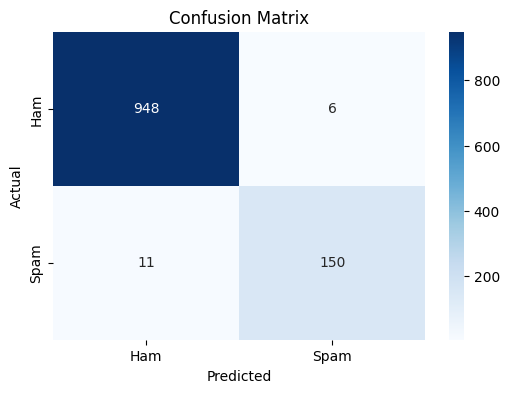

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       954
        Spam       0.96      0.93      0.95       161

    accuracy                           0.98      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy: 0.98


In [63]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = [1 if classify_message(msg) == "spam" else 0 for msg in X_test]

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizing Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Ham", "Spam"]))

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
